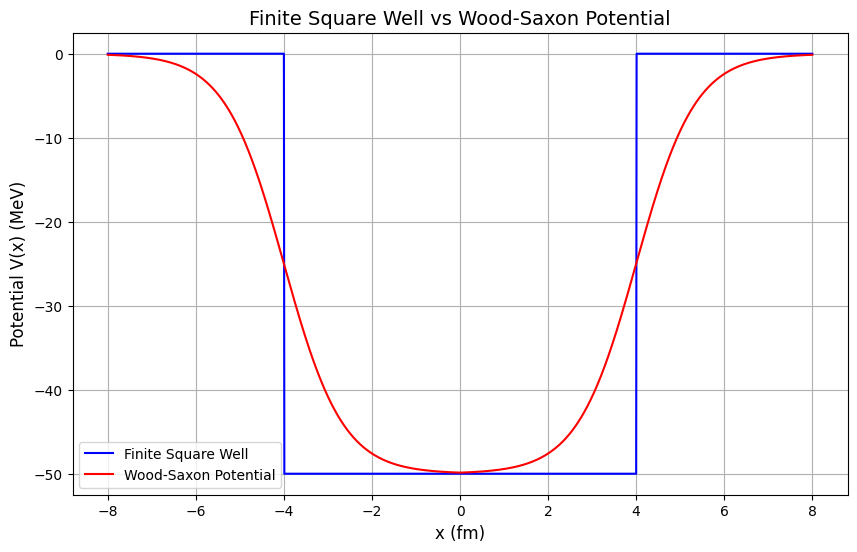

Numerical Eigenvalues for Finite Square Well (MeV):
n=1: E=-48.711627 MeV
n=2: E=-44.860834 MeV
n=3: E=-38.495622 MeV
n=4: E=-29.717997 MeV

Analytical Eigenvalues for Finite Square Well (MeV):
n=1: E=-48.711617 MeV
n=2: E=-48.400045 MeV
n=3: E=-38.495542 MeV
n=4: E=-35.600401 MeV

Numerical Eigenvalues for Wood-Saxon Potential (MeV):
n=1: E=-47.196351 MeV
n=2: E=-40.897498 MeV
n=3: E=-32.937500 MeV
n=4: E=-24.072987 MeV

WKB Approximation Eigenvalues for Wood-Saxon Potential (MeV):
n=1: E=-47.535618 MeV
n=2: E=-41.007069 MeV
n=3: E=-32.845824 MeV
n=4: E=-23.837287 MeV


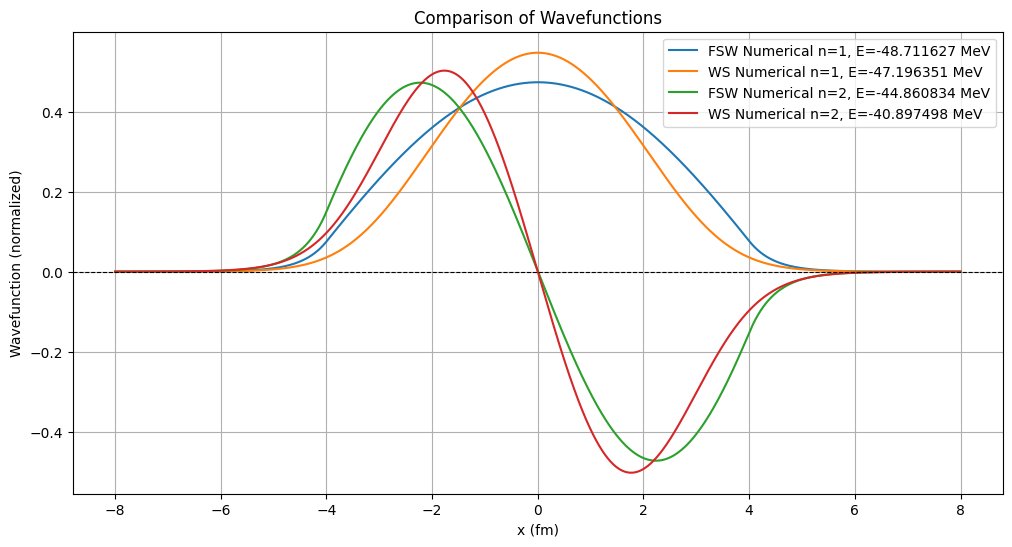

In [ ]:
import numpy as np
from scipy.optimize import root_scalar, fsolve
import matplotlib.pyplot as plt
import scipy.integrate as integrate

# Constants and parameters
hbar2_over_2m = 20.75  # MeV·fm²
V0 = 50.0  # MeV (depth of the potential)
R = 4.0  # fm (width or radius of the potential)
a0 = 0.67  # fm (diffuseness for Wood-Saxon potential)
h = 0.01  # Smaller mesh size for improved numerical accuracy
tolerance = 1e-8  # Higher energy convergence precision

# Potential functions
def V_fsw(x):
    return -V0 if abs(x) <= R else 0.0

def V_ws(x):
    return -V0 / (1 + np.exp((abs(x) - R) / a0))

# Numerov method
def numerov(E, x_grid, V_func):
    N = len(x_grid)
    psi = np.zeros(N)  # Wavefunction array
    k = 2 * (E - np.array([V_func(x) for x in x_grid])) / hbar2_over_2m  # k(x)

    # Initial conditions (ψ(0) = 0, small arbitrary ψ(h))
    psi[0] = 0.0
    psi[1] = 1e-5  # Small arbitrary value

    # Numerov propagation
    for i in range(1, N - 1):
        psi[i + 1] = (
            (2 * (1 - (5 / 12) * h**2 * k[i]) * psi[i]
             - (1 + (1 / 12) * h**2 * k[i - 1]) * psi[i - 1])
            / (1 + (1 / 12) * h**2 * k[i + 1])
        )

    return psi

# Shooting method to find eigenvalues
def shooting_method(n_nodes, x_grid, V_func):
    E_low, E_high = -V0, 0.0  # Energy range to search
    psi = None

    while E_high - E_low > tolerance:
        E_mid = (E_low + E_high) / 2
        psi = numerov(E_mid, x_grid, V_func)

        # Count the number of nodes
        nodes = np.sum(psi[:-1] * psi[1:] < 0)

        # Adjust the energy bounds
        if nodes > n_nodes:
            E_high = E_mid
        else:
            E_low = E_mid

    return E_mid, psi

# Analytical solution for FSW using transcendental equations
def even_condition(E):
    k = np.sqrt(2 * (E + V0) / hbar2_over_2m)
    kappa = np.sqrt(2 * (- E) / hbar2_over_2m)
    return k * np.tan(k * R) - kappa

def odd_condition(E):
    k = np.sqrt(2 * (E + V0) / hbar2_over_2m)
    kappa = np.sqrt(2 * (- E) / hbar2_over_2m)
    return k / np.tan(k * R) + kappa

def solve_transcendental(eq_func, E_start, E_end):
    """Find an eigenvalue in a given energy range."""
    solution = root_scalar(eq_func, bracket=[E_start, E_end], method='brentq')
    if solution.converged:
        return solution.root
    else:
        return None

# WKB method for WS
def wkb_quantization(n, x_min, x_max, energy):
    """Quantization condition integral for WKB approximation."""
    def integrand(x):
        V = V_ws(x)
        if energy > V:  # Ensure turning point condition
            return np.sqrt(2 * (energy - V) / hbar2_over_2m)
        return 0.0  # Outside classically allowed region

    integral, _ = integrate.quad(integrand, x_min, x_max)
    return integral - (n + 0.5) * np.pi

# Compute turning points for WS
def turning_points(energy, x_grid):
    """Find the classical turning points where E = V(x)."""
    potential = np.array([V_ws(x) for x in x_grid])
    x_allowed = x_grid[potential < energy]
    return x_allowed[0], x_allowed[-1]

# Find WKB eigenvalues for WS
def find_wkb_eigenvalues(n_levels, x_grid):
    eigenvalues = []
    for n in range(n_levels):
        E_min, E_max = -V0, 0  # Bound energy range
        while E_max - E_min > 1e-6:
            E_mid = (E_min + E_max) / 2
            x_min, x_max = turning_points(E_mid, x_grid)
            if wkb_quantization(n, x_min, x_max, E_mid) > 0:
                E_max = E_mid
            else:
                E_min = E_mid
        eigenvalues.append(E_mid)
    return eigenvalues

# Solve for eigenvalues
"""x_grid = np.arange(-8, 8, h) """
x_grid = np.arange(-2 * R, 2 * R+ h, h)
n_levels = 4
fsw_eigenvalues, ws_eigenvalues = [], []
fsw_wavefunctions, ws_wavefunctions = [], []
analytical_fsw_eigenvalues = []
wkb_ws_eigenvalues = []

# Numerical solution for FSW and WS
for n_nodes in range(n_levels):
    # Finite Square Well
    E_fsw, psi_fsw = shooting_method(n_nodes, x_grid, V_fsw)
    fsw_eigenvalues.append(E_fsw)
    fsw_wavefunctions.append(psi_fsw / np.sqrt(np.sum(psi_fsw**2) * h))  # Normalize

    # Wood-Saxon
    E_ws, psi_ws = shooting_method(n_nodes, x_grid, V_ws)
    ws_eigenvalues.append(E_ws)
    ws_wavefunctions.append(psi_ws / np.sqrt(np.sum(psi_ws**2) * h))  # Normalize

# Analytical solution for FSW
energy_range = np.linspace(-V0, 0, 1000)  # Search within [-V0, 0]
analytical_fsw_eigenvalues = []

for eq_func in [even_condition, odd_condition] * 2:  # Alternate even/odd conditions
    for i in range(len(energy_range) - 1):
        E1, E2 = energy_range[i], energy_range[i + 1]
        if eq_func(E1) * eq_func(E2) < 0:  # Root detected
            eigenvalue = solve_transcendental(eq_func, E1, E2)
            if eigenvalue is not None:
                analytical_fsw_eigenvalues.append(eigenvalue)
                if len(analytical_fsw_eigenvalues) == 4:  # Stop after finding 4 eigenvalues
                    break
    if len(analytical_fsw_eigenvalues) == 4:  # Break outer loop if 4 eigenvalues are found
        break


# Analytical WKB solution for WS
wkb_ws_eigenvalues = find_wkb_eigenvalues(n_levels, x_grid)

# Plot potentials
V_fsw_array = np.array([V_fsw(x) for x in x_grid])
V_ws_array = np.array([V_ws(x) for x in x_grid])

plt.figure(figsize=(10, 6))
plt.plot(x_grid, V_fsw_array, label="Finite Square Well", color="blue")
plt.plot(x_grid, V_ws_array, label="Wood-Saxon Potential", color="red")
plt.title("Finite Square Well vs Wood-Saxon Potential", fontsize=14)
plt.xlabel("x (fm)", fontsize=12)
plt.ylabel("Potential V(x) (MeV)", fontsize=12)
plt.legend()
plt.grid()
plt.show()

# Print eigenvalues
print("Numerical Eigenvalues for Finite Square Well (MeV):")
for n, energy in enumerate(fsw_eigenvalues, start=1):
    print(f"n={n}: E={energy:.6f} MeV")

print("\nAnalytical Eigenvalues for Finite Square Well (MeV):")
for n, energy in enumerate(analytical_fsw_eigenvalues, start=1):
    print(f"n={n}: E={energy:.6f} MeV")

print("\nNumerical Eigenvalues for Wood-Saxon Potential (MeV):")
for n, energy in enumerate(ws_eigenvalues, start=1):
    print(f"n={n}: E={energy:.6f} MeV")

print("\nWKB Approximation Eigenvalues for Wood-Saxon Potential (MeV):")
for n, energy in enumerate(wkb_ws_eigenvalues, start=1):
    print(f"n={n}: E={energy:.6f} MeV")

# Plot wavefunctions for first two levels
plt.figure(figsize=(12, 6))
for i in range(2):  # Loop over the first two levels
    # Plot numerical FSW wavefunction
    plt.plot(
        x_grid,
        fsw_wavefunctions[i],
        label=f"FSW Numerical n={i+1}, E={fsw_eigenvalues[i]:.6f} MeV"
    )

    # Plot numerical WS wavefunction
    plt.plot(
        x_grid,
        ws_wavefunctions[i],
        label=f"WS Numerical n={i+1}, E={ws_eigenvalues[i]:.6f} MeV"
    )

# Final plot setup
plt.title("Comparison of Wavefunctions")
plt.xlabel("x (fm)")
plt.ylabel("Wavefunction (normalized)")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.legend()
plt.grid()
plt.show()
